In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.rcParams['font.family'] = 'malgun gothic'

from sklearn.metrics import accuracy_score, log_loss, plot_confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier, Pool  
from lightgbm import LGBMClassifier   

from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

import warnings
warnings.filterwarnings(action='ignore')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 데이터 불러오기

In [2]:
df = pd.read_csv(r'..\..\..\Data\최종데이터셋\Finaldataset_ver7.2.csv', index_col=0)
df

,회사명,거래소코드,회계년도,소속코드,상장폐지일,감사의견코드,자기자본배당률,금융비용 대 부채비율,자기자본배율,유동부채비율,...,수시공시제목,대표이사 변경,최대주주 변경,회계처리위반,횡령배임,신종채권,영업조업중단,외국인_주식분포비율,종가,종가변동률
0,(주)CMG제약,58820.0,2000/12,5.0,0,UQ,0.00,0.019074,179.37,131.99,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000
1,(주)CMG제약,58820.0,2001/12,5.0,0,UQ,0.00,0.023517,179.37,131.99,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1420.0,-0.633803
2,(주)CMG제약,58820.0,2002/12,5.0,0,UQ,0.00,0.043081,133.37,132.37,...,0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,520.0,-0.633803
3,(주)CMG제약,58820.0,2003/12,5.0,0,UQ,0.00,0.058531,131.30,71.46,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,800.0,0.538462
4,(주)CMG제약,58820.0,2004/12,5.0,0,UQ,0.00,0.047346,52.25,101.56,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,550.0,-0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25119,흥구석유(주),24060.0,2015/12,5.0,0,UQ,1.70,0.005597,4548.48,4.01,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.60,3040.0,0.404157
25120,흥구석유(주),24060.0,2016/12,5.0,0,UQ,2.10,0.012651,4611.84,5.19,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.97,3425.0,0.126645
25121,흥구석유(주),24060.0,2017/12,5.0,0,UQ,2.08,0.012502,4650.29,12.83,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,2775.0,-0.189781
25122,흥구석유(주),24060.0,2018/12,5.0,0,UQ,2.48,0.018056,4696.15,5.40,...,0,0.0,0.0,0.0,0.0,0.0,0.0,1.73,2705.0,-0.025225


In [3]:
df.shape

(25124, 32)

In [4]:
df['부도'].value_counts()

0.0    24722
1.0      402
Name: 부도, dtype: int64

# 모델링 X_ft/X_finance

## 데이터 생성 

In [5]:
df.columns

Index(['회사명', '거래소코드', '회계년도', '소속코드', '상장폐지일', '감사의견코드', '자기자본배당률',
       '금융비용 대 부채비율', '자기자본배율', '유동부채비율', '매입채무회전률', '유동자산회전률', '총자본투자효율',
       '순운전자본비율', '누적수익성비율', '총자산영업이익률', '총자산회전율', '년', 'key', '부도', '공시발생일',
       '정기공시제목', '수시공시제목', '대표이사 변경', '최대주주 변경', '회계처리위반', '횡령배임', '신종채권',
       '영업조업중단', '외국인_주식분포비율', '종가', '종가변동률'],
      dtype='object')

In [6]:
#재무+비재무+시장데이터
col_f_t = [ '자기자본배당률',
       '금융비용 대 부채비율', '자기자본배율', '유동부채비율', '매입채무회전률', '유동자산회전률', '총자본투자효율',
       '순운전자본비율', '누적수익성비율', '총자산영업이익률', '총자산회전율', '대표이사 변경', '최대주주 변경', '회계처리위반', '횡령배임', '신종채권',
       '영업조업중단', '외국인_주식분포비율', '종가변동률'] #종가는 너무 커서 아직 안넣음 추후 로그 스케일링 진행예정

#재무데이터
col_f =  [ '자기자본배당률',
       '금융비용 대 부채비율', '자기자본배율', '유동부채비율', '매입채무회전률', '유동자산회전률', '총자본투자효율',
       '순운전자본비율', '누적수익성비율', '총자산영업이익률', '총자산회전율']

In [7]:
#feature finance+text
X_ft = df[col_f_t]
#feature only finance
X_finance = df[col_f]

y=df['부도']

In [8]:
y

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
25119    0.0
25120    0.0
25121    0.0
25122    0.0
25123    0.0
Name: 부도, Length: 25124, dtype: float64

In [9]:
X_ft

,자기자본배당률,금융비용 대 부채비율,자기자본배율,유동부채비율,매입채무회전률,유동자산회전률,총자본투자효율,순운전자본비율,누적수익성비율,총자산영업이익률,총자산회전율,대표이사 변경,최대주주 변경,회계처리위반,횡령배임,신종채권,영업조업중단,외국인_주식분포비율,종가변동률
0,0.00,0.019074,179.37,131.99,24.84,0.97,8.76,22.76,0.189100,0.052949,1.761228,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000
1,0.00,0.023517,179.37,131.99,24.84,0.97,8.76,22.76,0.005261,0.014062,0.756792,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.633803
2,0.00,0.043081,133.37,132.37,58.88,2.01,0.79,7.98,-0.139212,-0.247841,1.713785,1.0,0.0,0.0,0.0,0.0,1.0,0.00,-0.633803
3,0.00,0.058531,131.30,71.46,26.59,1.89,16.80,35.58,-0.203019,-0.082618,1.571816,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.538462
4,0.00,0.047346,52.25,101.56,24.16,2.11,-37.94,24.97,-1.181502,-0.547982,2.526356,1.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25119,1.70,0.005597,4548.48,4.01,114471.12,10.28,10.04,14.15,0.408384,0.005919,1.987188,0.0,0.0,0.0,0.0,0.0,0.0,0.60,0.404157
25120,2.10,0.012651,4611.84,5.19,179576.67,10.07,8.84,14.15,0.414800,0.012181,1.817620,0.0,0.0,0.0,0.0,0.0,0.0,0.97,0.126645
25121,2.08,0.012502,4650.29,12.83,5044.25,10.14,8.80,8.68,0.417422,0.009398,1.946103,0.0,0.0,0.0,0.0,0.0,0.0,0.03,-0.189781
25122,2.48,0.018056,4696.15,5.40,5128.70,11.71,9.80,11.59,0.453302,0.014520,2.210036,0.0,0.0,0.0,0.0,0.0,0.0,1.73,-0.025225


In [10]:
X_finance

,자기자본배당률,금융비용 대 부채비율,자기자본배율,유동부채비율,매입채무회전률,유동자산회전률,총자본투자효율,순운전자본비율,누적수익성비율,총자산영업이익률,총자산회전율
0,0.00,0.019074,179.37,131.99,24.84,0.97,8.76,22.76,0.189100,0.052949,1.761228
1,0.00,0.023517,179.37,131.99,24.84,0.97,8.76,22.76,0.005261,0.014062,0.756792
2,0.00,0.043081,133.37,132.37,58.88,2.01,0.79,7.98,-0.139212,-0.247841,1.713785
3,0.00,0.058531,131.30,71.46,26.59,1.89,16.80,35.58,-0.203019,-0.082618,1.571816
4,0.00,0.047346,52.25,101.56,24.16,2.11,-37.94,24.97,-1.181502,-0.547982,2.526356
...,...,...,...,...,...,...,...,...,...,...,...
25119,1.70,0.005597,4548.48,4.01,114471.12,10.28,10.04,14.15,0.408384,0.005919,1.987188
25120,2.10,0.012651,4611.84,5.19,179576.67,10.07,8.84,14.15,0.414800,0.012181,1.817620
25121,2.08,0.012502,4650.29,12.83,5044.25,10.14,8.80,8.68,0.417422,0.009398,1.946103
25122,2.48,0.018056,4696.15,5.40,5128.70,11.71,9.80,11.59,0.453302,0.014520,2.210036


## under sampling 체크

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size=0.3, stratify=y, random_state=46)
cc = RandomUnderSampler(random_state=42) #train만 언더샘플링 진행
X_train_under, y_train_under = cc.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_train_under.shape)


(17586, 19)
(562, 19)


## 함수생성

In [12]:
#finance + text 임계점 default
def ft_modeling(model):
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size=0.3, stratify=y, random_state=46)
    cc = RandomUnderSampler(random_state=42) #train만 언더샘플링 진행
    X_train_under, y_train_under = cc.fit_resample(X_train, y_train)
    clf=model

    clf.fit(X_train_under, y_train_under)
    y_pred = clf.predict(X_test)
    y_true = y_test
    print(confusion_matrix(y_true, y_pred)) #confusion_matrix
    print('Recall score : ', recall_score(y_true, y_pred, average='macro')) # 스코어
    print('precision score : ', precision_score(y_true, y_pred, average='macro'))
    print('f1_score : ', f1_score(y_true, y_pred, average='macro'))
    print("roc_auc_score: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    print("pr_auc_score: {:.3f}".format(average_precision_score(y_test, y_pred)))
    feat_importances = pd.Series(clf.feature_importances_ , index= X_train.columns)
    print(feat_importances.plot(kind = 'barh')) #feature_importances

In [13]:
#finance + text 임계점 조절 가능
def ft_modeling_thre(model, threshold):
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size=0.3, stratify=y, random_state=46)
    cc = RandomUnderSampler(random_state=42) #train만 언더샘플링 진행
    X_train_under, y_train_under = cc.fit_resample(X_train, y_train)
    clf=model

    clf.fit(X_train_under, y_train_under)
    y_pred = clf.predict_proba(X_test)
    y_pred = (y_pred[:,1] > threshold) * 1 #임계점 조절
    y_true = y_test
    print(confusion_matrix(y_true, y_pred)) #confusion_matrix
    print('Recall score : ', recall_score(y_true, y_pred, average='macro')) # 스코어
    print('precision score : ', precision_score(y_true, y_pred, average='macro'))
    print('f1_score : ', f1_score(y_true, y_pred, average='macro'))
    print("roc_auc_score: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    print("pr_auc_score: {:.3f}".format(average_precision_score(y_test, y_pred)))
    feat_importances = pd.Series(clf.feature_importances_ , index= X_train.columns)
    print(feat_importances.plot(kind = 'barh')) #feature_importances

In [14]:
#only finance feature 임계점 default
def finance_modeling(model):
    X_train, X_test, y_train, y_test = train_test_split(X_finance, y, test_size=0.3, stratify=y, random_state=46)
    cc = RandomUnderSampler(random_state=42) #train만 언더샘플링 진행
    X_train_under, y_train_under = cc.fit_resample(X_train, y_train)
    clf=model

    clf.fit(X_train_under, y_train_under)
    y_pred = clf.predict(X_test)
    y_true = y_test
    print(confusion_matrix(y_true, y_pred)) #confusion_matrix
    print('Recall score : ', recall_score(y_true, y_pred, average='macro')) # 스코어
    print('precision score : ', precision_score(y_true, y_pred, average='macro'))
    print('f1_score : ', f1_score(y_true, y_pred, average='macro'))
    print("roc_auc_score: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    print("pr_auc_score: {:.3f}".format(average_precision_score(y_test, y_pred)))
    feat_importances = pd.Series(clf.feature_importances_ , index= X_train.columns)
    print(feat_importances.plot(kind = 'barh')) #feature_importances

In [15]:
#fonly finance 임계점 조절 가능
def finance_modeling_thre(model, threshold):
    X_train, X_test, y_train, y_test = train_test_split(X_finance, y, test_size=0.3, stratify=y, random_state=46)
    cc = RandomUnderSampler(random_state=42) #train만 언더샘플링 진행
    X_train_under, y_train_under = cc.fit_resample(X_train, y_train)
    clf=model

    clf.fit(X_train_under, y_train_under)
    y_pred = clf.predict_proba(X_test)
    y_pred = (y_pred[:,1] > threshold) * 1 #임계점 조절
    y_true = y_test
    print(confusion_matrix(y_true, y_pred)) #confusion_matrix
    print('Recall score : ', recall_score(y_true, y_pred, average='macro')) # 스코어
    print('precision score : ', precision_score(y_true, y_pred, average='macro'))
    print('f1_score : ', f1_score(y_true, y_pred, average='macro'))
    print("roc_auc_score: {:.3f}".format(roc_auc_score(y_test, y_pred)))
    print("pr_auc_score: {:.3f}".format(average_precision_score(y_test, y_pred)))
    feat_importances = pd.Series(clf.feature_importances_ , index= X_train.columns)
    print(feat_importances.plot(kind = 'barh')) #feature_importances

In [ ]:
"""
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic') #한글 폰트 설정
#precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.decision_function(x_test)) #곡선 그리기
precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:,0])
#score = metrics.average_precision_score(y_test, model.decision_function(X_test)) #AP(Average Precision)
score = metrics.average_precision_score(y_test, model.predict_proba(X_test)[:,0]) 
plt.plot(recall, precision, label='Precision (정밀도) - Recall (재현율) 곡선, AP(면적) = {:.3f}'.format(score))
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel("Recall (재현율)")
plt.ylabel("Precision (정밀도)")
plt.title('Precision (정밀도) - Recall (재현율) 곡선')
plt.legend(loc="best")
plt.show()
"""

In [ ]:
""""
import matplotlib.pylab as plt
import matplotlib as mpl
from sklearn import metrics
model=RandomForestClassifier()
model.fit(X_train, y_train)
mpl.rc('font', family='Malgun Gothic') #한글 폰트 설정
#precision, recall, thresholds = metrics.precision_recall_curve(y_test, clf.decision_function(X_test)) #곡선 그리기
precision, recall, thresholds = metrics.precision_recall_curve(y_test, model.predict_proba(X_test)[:,0])
plt.plot(thresholds, precision[:-1], "b--", label="정밀도")
plt.plot(thresholds, recall[:-1], "g-", label="재현율")
plt.xlabel("결정 임계값")
plt.ylabel("정밀도/재현율")
plt.title('결정 임계값에 대한 정밀도와 재현율')
plt.legend(loc="best")
plt.show()
"""

### RF

[[6708  709]
 [  13  108]]
Recall score :  0.8984853870436132
precision score :  0.5651283532478355
f1_score :  0.5896045709652734
roc_auc_score: 0.898
pr_auc_score: 0.120
AxesSubplot(0.125,0.125;0.775x0.755)


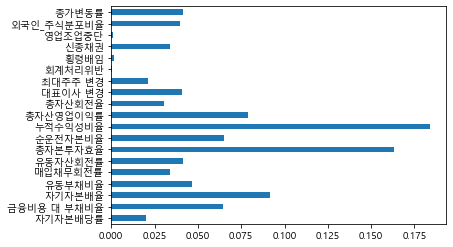

In [16]:
ft_modeling(RandomForestClassifier())

[[6421  996]
 [  15  106]]
Recall score :  0.8708734791750468
precision score :  0.5469290537911182
f1_score :  0.5501818268315385
roc_auc_score: 0.871
pr_auc_score: 0.086
AxesSubplot(0.125,0.125;0.775x0.755)


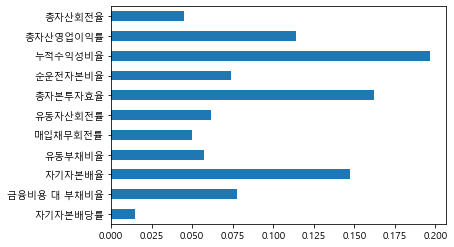

In [17]:
finance_modeling(RandomForestClassifier())

[[5014 1805]
 [   7  110]]
Recall score :  0.8377346855129522
precision score :  0.5280235543354985
f1_score :  0.4776135879974463
roc_auc_score: 0.838
pr_auc_score: 0.055
AxesSubplot(0.125,0.125;0.775x0.755)


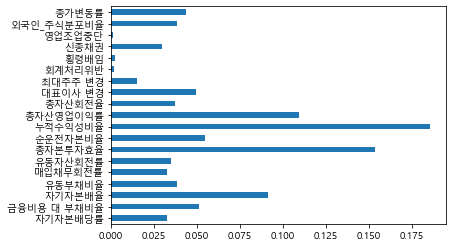

In [184]:
ft_modeling_thre(RandomForestClassifier(), 0.3)

[[4794 2025]
 [  11  106]]
Recall score :  0.8045092708533096
precision score :  0.5237263116054517
f1_score :  0.4595755988958909
roc_auc_score: 0.805
pr_auc_score: 0.047
AxesSubplot(0.125,0.125;0.775x0.755)


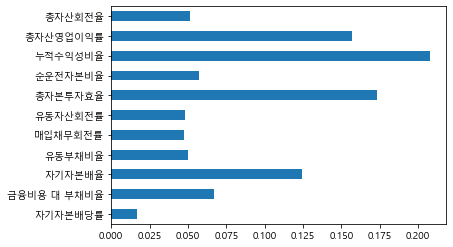

In [156]:
finance_modeling_thre(RandomForestClassifier(), 0.3)

### catboost

Learning rate set to 0.007969
0:	learn: 0.6870686	total: 2.34ms	remaining: 2.34s
1:	learn: 0.6806459	total: 4.4ms	remaining: 2.2s
2:	learn: 0.6744650	total: 6.39ms	remaining: 2.12s
3:	learn: 0.6676362	total: 8.37ms	remaining: 2.08s
4:	learn: 0.6616069	total: 10.2ms	remaining: 2.02s
5:	learn: 0.6556165	total: 12.8ms	remaining: 2.12s
6:	learn: 0.6499891	total: 15.3ms	remaining: 2.16s
7:	learn: 0.6436980	total: 17.6ms	remaining: 2.19s
8:	learn: 0.6375104	total: 19.6ms	remaining: 2.16s
9:	learn: 0.6310602	total: 21.4ms	remaining: 2.12s
10:	learn: 0.6261075	total: 23.1ms	remaining: 2.08s
11:	learn: 0.6200616	total: 25ms	remaining: 2.06s
12:	learn: 0.6141704	total: 27.6ms	remaining: 2.09s
13:	learn: 0.6082563	total: 29.9ms	remaining: 2.1s
14:	learn: 0.6028464	total: 32ms	remaining: 2.1s
15:	learn: 0.5972863	total: 34.2ms	remaining: 2.1s
16:	learn: 0.5920311	total: 36.5ms	remaining: 2.11s
17:	learn: 0.5876749	total: 38.6ms	remaining: 2.1s
18:	learn: 0.5823841	total: 40.8ms	remaining: 2.1s
19:

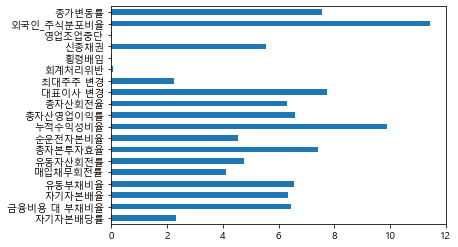

In [157]:
ft_modeling(CatBoostClassifier())
#[6166  653]
#[  15  102]

Learning rate set to 0.007969
0:	learn: 0.6862163	total: 2.29ms	remaining: 2.28s
1:	learn: 0.6797235	total: 4.25ms	remaining: 2.12s
2:	learn: 0.6740381	total: 6.17ms	remaining: 2.05s
3:	learn: 0.6677571	total: 8.12ms	remaining: 2.02s
4:	learn: 0.6618136	total: 10.9ms	remaining: 2.17s
5:	learn: 0.6560460	total: 12.8ms	remaining: 2.12s
6:	learn: 0.6507303	total: 14.7ms	remaining: 2.08s
7:	learn: 0.6449050	total: 16.7ms	remaining: 2.07s
8:	learn: 0.6394249	total: 18.7ms	remaining: 2.06s
9:	learn: 0.6335849	total: 20.6ms	remaining: 2.04s
10:	learn: 0.6282009	total: 22.7ms	remaining: 2.04s
11:	learn: 0.6230257	total: 32.5ms	remaining: 2.67s
12:	learn: 0.6178521	total: 34.4ms	remaining: 2.61s
13:	learn: 0.6128740	total: 36.3ms	remaining: 2.55s
14:	learn: 0.6081361	total: 38.4ms	remaining: 2.52s
15:	learn: 0.6034701	total: 41.2ms	remaining: 2.53s
16:	learn: 0.5990319	total: 43.3ms	remaining: 2.5s
17:	learn: 0.5944550	total: 45.3ms	remaining: 2.47s
18:	learn: 0.5894173	total: 47.4ms	remaining:

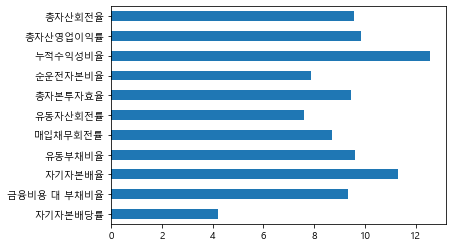

In [159]:
finance_modeling(CatBoostClassifier())
#[[5725 1094]
#[  19   98]]

### Adaboost

[[5850  969]
 [  13  104]]
Recall score :  0.8733929706213033
precision score :  0.5473536079086962
f1_score :  0.5486786671773267
roc_auc_score: 0.873
pr_auc_score: 0.088
AxesSubplot(0.125,0.125;0.775x0.755)


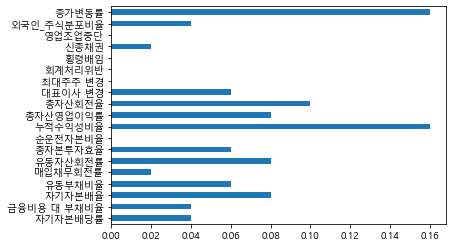

In [160]:
ft_modeling(AdaBoostClassifier())

[[ 106 6713]
 [   0  117]]
Recall score :  0.5077724006452559
precision score :  0.5085651537335285
f1_score :  0.0321486614225604
roc_auc_score: 0.508
pr_auc_score: 0.017
AxesSubplot(0.125,0.125;0.775x0.755)


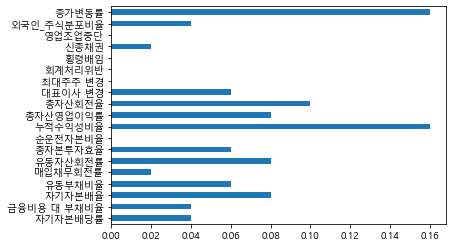

In [164]:
#임계값 조절 안한게 더 성능 좋음 
ft_modeling_thre(AdaBoostClassifier(), 0.3)

[[5568 1251]
 [  20   97]]
Recall score :  0.8228009220090171
precision score :  0.5341896794530033
f1_score :  0.5149905192241195
roc_auc_score: 0.823
pr_auc_score: 0.063
AxesSubplot(0.125,0.125;0.775x0.755)


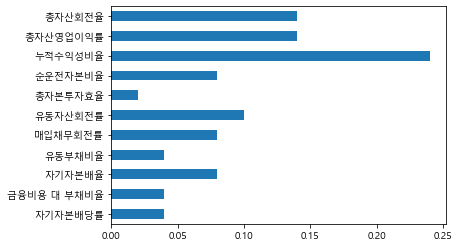

In [166]:
finance_modeling(AdaBoostClassifier())

[[   0 6819]
 [   0  117]]
Recall score :  0.5
precision score :  0.008434256055363323
f1_score :  0.016588685665674185
roc_auc_score: 0.500
pr_auc_score: 0.017
AxesSubplot(0.125,0.125;0.775x0.755)


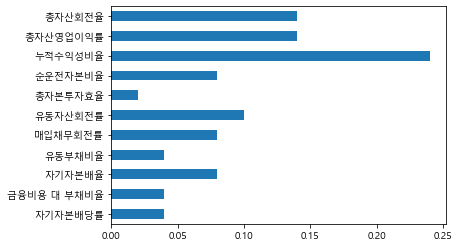

In [165]:
finance_modeling_thre(AdaBoostClassifier(), 0.3)

### LGBM

[[6060  759]
 [  11  106]]
Recall score :  0.8973381313900451
precision score :  0.5603657299984861
f1_score :  0.5780748587057334
roc_auc_score: 0.897
pr_auc_score: 0.113
AxesSubplot(0.125,0.125;0.775x0.755)


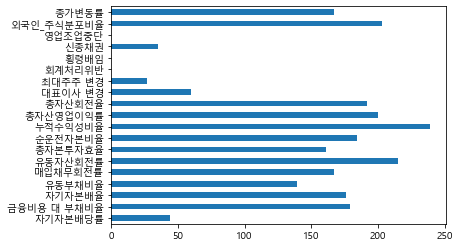

In [167]:
ft_modeling(LGBMClassifier())

[[4215 2604]
 [   4  113]]
Recall score :  0.7919688953564888
precision score :  0.5203209484967447
f1_score :  0.4217356273439429
roc_auc_score: 0.792
pr_auc_score: 0.041
AxesSubplot(0.125,0.125;0.775x0.755)


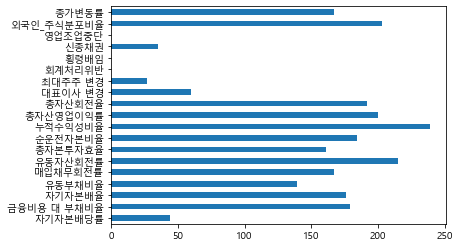

In [168]:
ft_modeling_thre(LGBMClassifier(), 0.025)

[[5703 1116]
 [  20   97]]
Recall score :  0.83269973415156
precision score :  0.5382361766401867
f1_score :  0.5276444979455496
roc_auc_score: 0.833
pr_auc_score: 0.069
AxesSubplot(0.125,0.125;0.775x0.755)


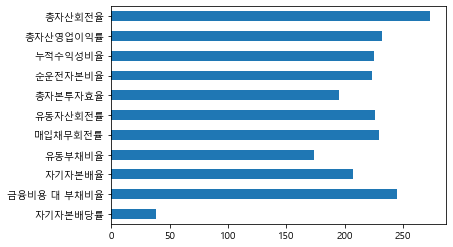

In [169]:
finance_modeling(LGBMClassifier())

# 할일
1. 임계값 대입
2. 각자 만든 파일 합치기 - def 생성
3. cat 해보기
4. ROC/ PR AUC